# WA9VNJ Eclipse Observations

In [1]:
import os
import datetime
import string
letters = string.ascii_lowercase

from tqdm.notebook import tqdm

import numpy as np
import pandas as pd

import matplotlib as mpl
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from astropy.coordinates import EarthLocation

import harc_plot
from harc_plot import geopack
import eclipse_calc

%matplotlib inline

Re = 6371 # Radius of the Earth in km

In [2]:
mpl.rcParams['font.size']      = 12
mpl.rcParams['font.weight']    = 'bold'
mpl.rcParams['axes.grid']      = True
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['figure.figsize'] = np.array([15, 8])
mpl.rcParams['axes.xmargin']   = 0

## Station Data

In [3]:
stations    = []
g = {}
g['call_sign'] = 'WWV'
g['lat']       =  40.68
g['lon']       = -105.04
stations.append(g)

g = {}
g['call_sign'] = 'WA9VNJ'
g['lat']       =  43.218
g['lon']       = -87.951
stations.append(g)

stations_df = pd.DataFrame(stations)
stations_df.set_index('call_sign',inplace=True)

tmp_lst = []
tx_call = 'WWV'
for call_sign,row in stations_df.iterrows():
    print(call_sign)
    if call_sign == tx_call:
        tmp_lst.append(row)
        continue
    
    lat_0 = stations_df.loc[tx_call]['lat']
    lon_0 = stations_df.loc[tx_call]['lon']
    lat_1 = row['lat']
    lon_1 = row['lon']
    
    rng      = Re*geopack.greatCircleDist(lat_0,lon_0,lat_1,lon_1)
    azm_from = geopack.greatCircleAzm(lat_0,lon_0,lat_1,lon_1)
    azm_to   = geopack.greatCircleAzm(lat_1,lon_1,lat_0,lon_0)
    
    res      = geopack.greatCircleMove(lat_0,lon_0,rng/2.,azm_from,Re=Re)
    
    row['mid_lat'] = res[0][0]
    row['mid_lon'] = res[1][0]
    
    row['azm_to_{!s}'.format(tx_call)]   = azm_to
    row['azm_from_{!s}'.format(tx_call)] = azm_from
    row['range_km'] = rng
    
    tmp_lst.append(row)
    
stations_df = pd.DataFrame(tmp_lst)

mid_lat = stations_df.loc['WA9VNJ']['mid_lat']
mid_lon = stations_df.loc['WA9VNJ']['mid_lon']

stations_df

WWV
WA9VNJ


,lat,lon,mid_lat,mid_lon,azm_to_WWV,azm_from_WWV,range_km
WWV,40.680,-105.040,NaN,NaN,NaN,NaN,NaN
WA9VNJ,43.218,-87.951,42.26699,-96.666892,-95.473566,73.053195,1438.470317


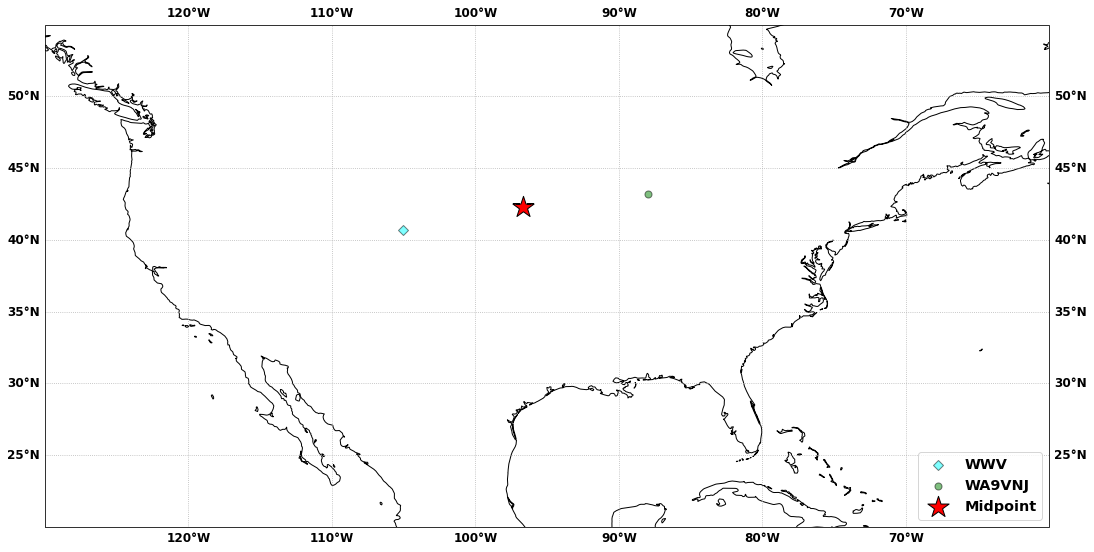

In [4]:
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(18,14))
ax  = fig.add_subplot(1,1,1,projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)

alpha = 0.5
# Plot Transmitter
call = 'WWV'
lat  = stations_df.loc[call]['lat']
lon  = stations_df.loc[call]['lon']
ax.scatter([lon],[lat],marker='D',s=50,color='Cyan',label=call,ec='black',alpha=alpha)

# Plot Receiver
call = 'WA9VNJ'
lat  = stations_df.loc[call]['lat']
lon  = stations_df.loc[call]['lon']
ax.scatter([lon],[lat],marker='o',s=50,color='green',label=call,ec='black',alpha=alpha)

# Plot Midpoint
call = 'WA9VNJ'
lat  = stations_df.loc[call]['mid_lat']
lon  = stations_df.loc[call]['mid_lon']
ax.scatter([lon],[lat],marker='*',s=500,color='red',label='Midpoint',ec='black')

ax.legend(loc='lower right',fontsize='large')
    
# # World Limits
# ax.set_xlim(-180,180)
# ax.set_ylim(-90,90)

# US Limits
ax.set_xlim(-130,-60)
ax.set_ylim(20,55)

plt.show()

## Load Eclipse Data

In [5]:
fpath = os.path.join('data','wa9vnj','eclipse_compare.csv')
def date_parser(year,month,day,hour,minute,second):
    yr = int(year)
    mo = int(month)
    da = int(day)
    hr = int(hour)
    mn = int(minute)
    sc = int(float(second))
    ms = int((float(second) % 60) * 1000)
    return datetime.datetime(yr,mo,da,hr,mn,sc,ms)

df    = pd.read_csv(fpath,parse_dates={'date':[0,1,2,3,4,5]},date_parser=date_parser)
df['df_hz'] = df['freq_MHz'] - 10e6

df['slt_mid'] = (df['utc_hr'] + mid_lon/15.) % 24.
az_el = harc_plot.gl.sunAzEl(df['date'],mid_lat,mid_lon)
df['sza_mid'] = az_el[1]

df

/home/w2naf/anaconda3/lib/python3.9/site-packages/pandas/io/parsers/base_parser.py:1055: FutureWarning: 
        Use pd.to_datetime instead.

  return generic_parser(date_parser, *date_cols)


,date,freq_MHz,utc_hr,df_hz,slt_mid,sza_mid
0,2017-08-20 13:57:14.014300,1.000000e+07,13.953972,0.1118,7.509513,65.667511
1,2017-08-20 13:57:26.026200,1.000000e+07,13.957278,0.1125,7.512818,65.630765
2,2017-08-20 13:57:38.038100,1.000000e+07,13.960583,0.0980,7.516124,65.594021
3,2017-08-20 13:57:50.050000,1.000000e+07,13.963889,0.0885,7.519429,65.557279
4,2017-08-20 13:58:01.001900,1.000000e+07,13.967194,0.0072,7.522735,65.523600
...,...,...,...,...,...,...
4864,2017-08-21 21:58:44.044300,1.000000e+07,21.978972,-0.0045,15.534513,54.460335
4865,2017-08-21 21:58:56.056200,1.000000e+07,21.982278,-0.0547,15.537818,54.495540
4866,2017-08-21 21:59:08.008100,1.000000e+07,21.985583,-0.0120,15.541124,54.530754
4867,2017-08-21 21:59:19.019900,1.000000e+07,21.988861,-0.0117,15.544402,54.563040


In [6]:
xlim = (0,24)
ecl_date = datetime.datetime(2017,8,21)

obsc_sDate = ecl_date + datetime.timedelta(hours=xlim[0])
obsc_eDate = ecl_date + datetime.timedelta(hours=xlim[1])

obsc_dates = [obsc_sDate]
while obsc_dates[-1] < obsc_eDate:
    obsc_dates.append(obsc_dates[-1]+datetime.timedelta(minutes=5))

loc  = EarthLocation.from_geodetic(mid_lon,mid_lat,height=300e3)
obsc    = []
obsc_ut = []

for obsc_date in tqdm(obsc_dates,dynamic_ncols=True,desc='Computing Eclipse Obscuration'):
    obsc.append(eclipse_calc.calculate_obscuration(obsc_date,loc=loc))
    obsc_ut.append(obsc_date.hour+obsc_date.minute/60.+obsc_date.second/3600.)

Computing Eclipse Obscuration:   0%|                                                                          …

## Plot Data

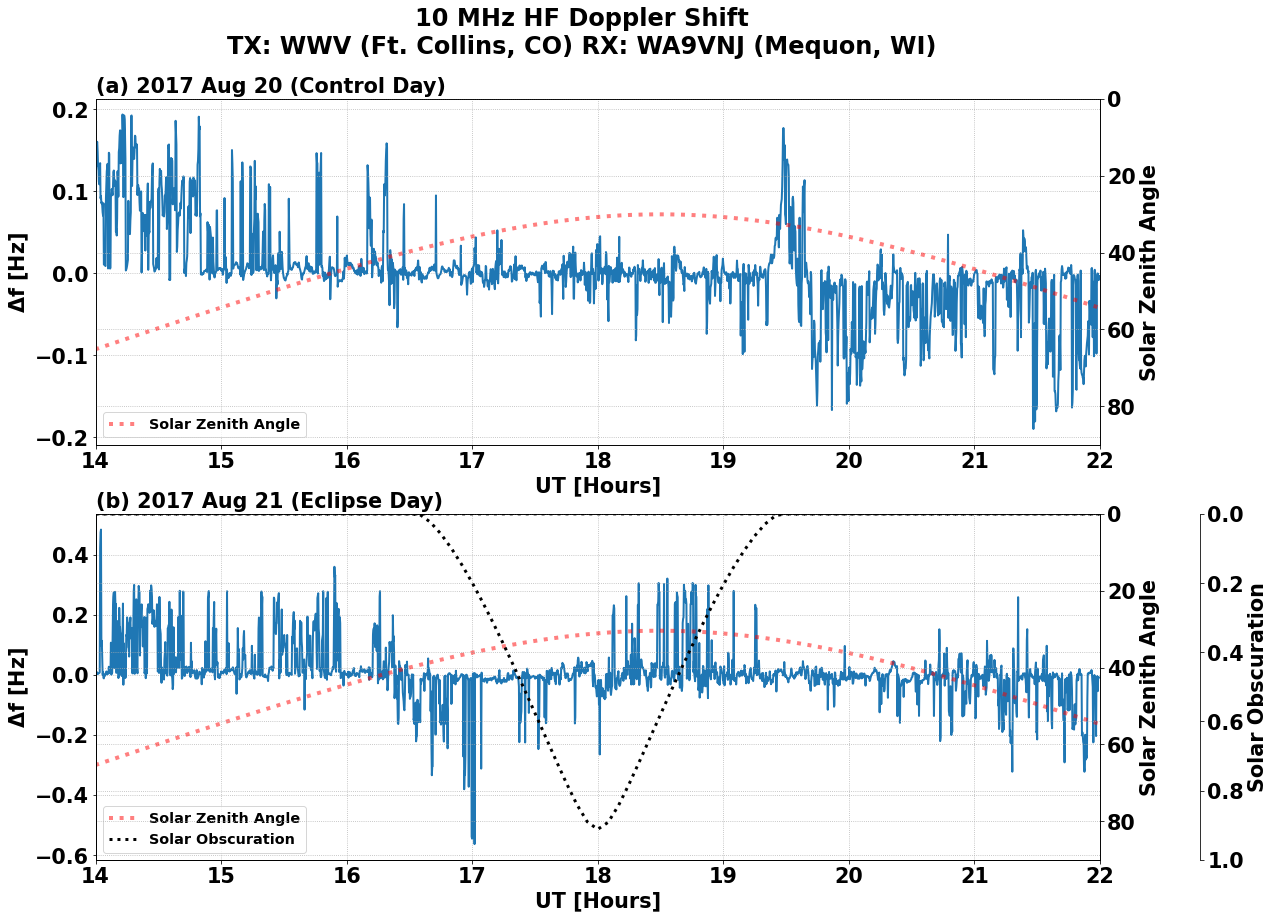

In [7]:
dates = []
dates.append(datetime.datetime(2017,8,20))
dates.append(datetime.datetime(2017,8,21))

xlim  = (14, 22)

nrows = len(dates)
ncols = 1

fig = plt.figure(figsize=(18,14))
for inx,date in enumerate(dates):
    ax = fig.add_subplot(nrows,ncols,inx+1)
    
    sDate = date
    eDate = date + datetime.timedelta(days=1)
    tf    = np.logical_and(df['date'] > sDate, df['date'] <= eDate)
    dft   = df[tf].copy()
    
 
    ax.set_xlim(xlim)
    ax.set_xlabel('UT [Hours]')
    ax.set_ylabel('$\Delta$f [Hz]')
    
    handles = []
    
    # Plot solar zenith angle
    ax_1 = ax.twinx()
    xx = dft['utc_hr']
    yy = dft['sza_mid']
    p_sza, = ax_1.plot(xx,yy,ls=':',color='red',lw=4,alpha=0.5,label='Solar Zenith Angle')
    handles.append(p_sza)
    ax_1.set_ylim(90,0)
    ax_1.set_ylabel('Solar Zenith Angle')
    # ax_1.yaxis.label.set_color(p.get_color())
    
    # Plot Eclipse Obscuration
    ecl_date = datetime.datetime(2017,8,21)
    if date == ecl_date:            
        ax_2 = ax.twinx()
        xx = obsc_ut
        yy = obsc
        p_obsc, = ax_2.plot(xx,yy,ls=':',lw=3,color='k',label='Solar Obscuration')
        handles.append(p_obsc)
        ax_2.set_ylim(1,0)
        ax_2.set_ylabel('Solar Obscuration')
        ax_2.spines['right'].set_position(("axes",1.1))
        
    xx = dft['utc_hr']
    yy = dft['df_hz']
    ax.plot(xx,yy,zorder=1000,lw=2)
    
    # ax.legend(['Solar Zenith Angle'],[p_sza],loc='lower left')
    ax.legend(handles=handles,loc='lower left')
        
    date_str = date.strftime('%Y %b %d')
    if date == datetime.datetime(2017,8,20):
        date_str = date_str + ' (Control Day)'
    elif date == ecl_date:
        date_str = date_str + ' (Eclipse Day)'
    ltitle = '({!s}) {!s}'.format(letters[inx],date_str)
    ax.set_title(ltitle,loc='left')

title = '10 MHz HF Doppler Shift\nTX: WWV (Ft. Collins, CO) RX: WA9VNJ (Mequon, WI)'
fontdict = {'size':24}
fig.text(0.5,0.925,title,ha='center',fontdict=fontdict)
    
plt.show()